In [1]:
# General Imports
import pandas as pd, numpy as np, gc as gc

# String Manipulation
import re, string
from sklearn.feature_extraction.text import CountVectorizer

# NLTK
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Preprocessing
from sklearn.preprocessing import Normalizer, StandardScaler

# Clustering
import umap
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import silhouette_score

# Plotting
import seaborn as sns, matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split, cross_validate, StratifiedShuffleSplit, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from imblearn.under_sampling import RandomUnderSampler

gc.enable()

In [2]:
# Load Amazon, convert to 2-class
amazon = pd.read_csv('amazon_data.csv')

In [3]:
# Helper Functions

# This function cleans the passed in paragraph and parses it
def get_words(para):   
    # Create a set of stop words
    stop_words = set(stopwords.words('english'))
    
    # Remove integers, stop words, empty characters, punctuation, and split into lowercase words
               
    # Perform stemming
    stemmed_tokens = [SnowballStemmer('english').stem(word) for word in [re.sub('[0-9]', '', i) for i in (nopunc.translate(str.maketrans('', '', string.punctuation)) for nopunc in para.lower().split()) if i.strip() not in stop_words and len(i.strip()) > 1]   ]
    
    return stemmed_tokens 

In [4]:
def parse_data(dataset, text_column, class_column, minimum=0.02, maximum=0.99, vectorize=False):
    
    # Create a corpus from the text of the df
    s = pd.Series(dataset[text_column]).astype('str')
    corpus = s.apply(lambda s: ' '.join(get_words(s)))
    
    # Separate the classes out
    classes = dataset[class_column]
    
    # Build the vectorizer object
    trimmed_count_vectorizer = CountVectorizer(strip_accents='unicode', min_df=minimum, max_df = maximum)

    # Create the vectors    
    trimmed_count = trimmed_count_vectorizer.fit_transform(corpus)

    # Now, apply each of these vectorizers to the data and create dataframes
    gc.collect()

    # Create the dataframes
    trimmed_count_df = pd.DataFrame(data = trimmed_count.todense(), columns = trimmed_count_vectorizer.get_feature_names())
    trimmed_count_df['_Class'] = classes

    # Free up some memory
    gc.collect()    

    # Return objects
    if vectorize:
        return trimmed_count_df, trimmed_count_vectorizer
    else:
        return trimmed_count_df

In [5]:
amazon['Rating'].value_counts()

5.0    14550
1.0     9161
2.0     5401
4.0     5324
Name: Rating, dtype: int64

In [6]:
amazon_data, amazon_vectorizer = parse_data(amazon, 'Text', 'Rating', vectorize=True)

# Rebalance the Amazon data
amazon_data = pd.concat( \
    [amazon_data.loc[amazon_data['_Class']==1.0].groupby(list(amazon_data.columns)).head(n=10000).sample(n=5324), 
     amazon_data.loc[amazon_data['_Class']==2.0].groupby(list(amazon_data.columns)).head(n=10000).sample(n=5324),
     amazon_data.loc[amazon_data['_Class']==5.0].groupby(list(amazon_data.columns)).head(n=10000).sample(n=5324),
     amazon_data.loc[amazon_data['_Class']==4.0]
    ]   
)

d:\Git\wip\_venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [7]:
amazon_data['_Class'].value_counts(normalize=True)

1.0    0.25
2.0    0.25
5.0    0.25
4.0    0.25
Name: _Class, dtype: float64

# Clustering Investigation

In [8]:
# Try clustering the data
reducer = umap.UMAP(n_neighbors=10, n_components=2)

In [9]:
def run_umap(data, classes, name, neighbors=10):
    algo = umap.UMAP(n_components=2, n_neighbors=neighbors, n_jobs=4)
    fitted_data = algo.fit_transform(StandardScaler().fit_transform(Normalizer().fit_transform(data)))

    plt.clf()
    plt.figure(figsize=(10,8))
    sns.set_style("darkgrid")

    sns.scatterplot(x=fitted_data[:,0], y=fitted_data[:,1], hue=classes).set(title="UMAP of {} Data for {} Neighbors".format(name, neighbors))
    plt.savefig('{}_{}'.format(name, neighbors))

In [10]:
amazon_classes = amazon_data['_Class']
amazon_data.drop('_Class', inplace=True, axis=1)

In [11]:
# for n in range(10, 110, 5):
#     run_umap(amazon_data, amazon_classes, name='Amazon', neighbors=n)

In [12]:
# for n in range(10, 110, 5):
#     run_umap(imdb_data, imdb_classes, name='IMDB', neighbors=n)

# Run Clustering

In [13]:
umapper = umap.UMAP(n_components=2, n_neighbors=35)
amazon_umap = umapper.fit_transform(StandardScaler().fit_transform(Normalizer().fit_transform(amazon_data.to_numpy())))

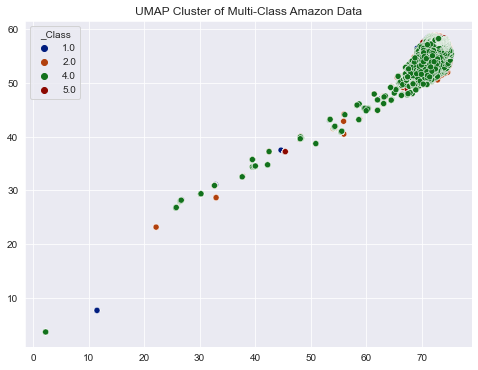

In [14]:
plt.figure(figsize=(8,6))
sns.set_style("darkgrid")

sns.scatterplot(x=amazon_umap[:,0], y=amazon_umap[:,1], hue=amazon_classes, palette="dark").set(title="UMAP Cluster of Multi-Class Amazon Data")
plt.show()

In [15]:
pca_2d = PCA(n_components=2)
# pca_3d = PCA(n_components=3)

amazon_2d_pca = pca_2d.fit_transform(StandardScaler().fit_transform(Normalizer().fit_transform(amazon_data.to_numpy())))
# amazon_3d_pca = pca_3d.fit_transform(StandardScaler().fit_transform(Normalizer().fit_transform(amazon_data.to_numpy())))

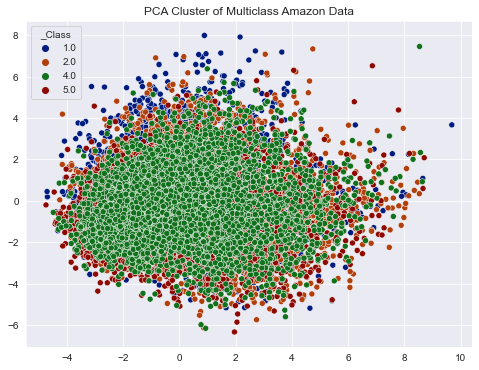

In [16]:
plt.figure(figsize=(8,6))
sns.set_style("darkgrid")

sns.scatterplot(x=amazon_2d_pca[:,0], y=amazon_2d_pca[:,1], hue=amazon_classes, palette="dark").set(title="PCA Cluster of Multiclass Amazon Data")
plt.show()

In [17]:
lda_2d = LinearDiscriminantAnalysis(n_components=2, tol=1.0e-1)
amazon_2d_lda = lda_2d.fit_transform(StandardScaler().fit_transform(Normalizer().fit_transform(amazon_data.to_numpy())), amazon_classes)

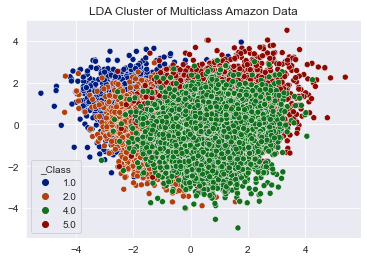

In [18]:
sns.scatterplot(x=amazon_2d_lda[:,0], y=amazon_2d_lda[:,1], hue=amazon_classes, palette="dark").set(title="LDA Cluster of Multiclass Amazon Data")
plt.show()

In [19]:
del amazon_2d_pca, amazon_umap, reducer, pca_2d, lda_2d
gc.collect()

59478

# Modeling

In [20]:
def evaluate_weight(X: pd.DataFrame, class_column: str, classifiers: list, data_name: str, weight:int=1):
    data = X.copy()

    # Store results
    names = []
    performances = []
    weights = []
    
    # Visualize the effects on class separation   
    # Figure out a way to combine these
    a = X.loc[X[class_column].isin([4.0, 5.0])]
    a.iloc[:,1:] = a.iloc[:,1:].mul(weight)
    b = X.loc[X[class_column].isin([1.0, 2.0])]
    data = pd.concat([a,b])
        
    # Break up classes
    classes = data[class_column]
    data.drop(class_column, inplace=True, axis=1)

    # Set up cross validation object
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=8)

    # Visualize the effects of the weighting
    pca = PCA(n_components=2)
    umapper = umap.UMAP(n_components=2, n_neighbors=25)
    lda = LinearDiscriminantAnalysis(n_components=2, tol=1e-1)
    
    plot_data = StandardScaler().fit_transform(Normalizer().fit_transform(data.to_numpy()))

    pca_data = pca.fit_transform(plot_data)
    umap_data = umapper.fit_transform(plot_data)
    lda_data = lda.fit_transform(plot_data, classes)

    pca_silhouette = silhouette_score(pca_data, classes)
    umap_silhouette = silhouette_score(umap_data, classes)
    lda_silhouette = silhouette_score(lda_data, classes)

    plt.figure(figsize=(10,8))
    sns.set_style("darkgrid")
    plt.clf()
    
    # Save PCA
    sns.scatterplot(x=pca_data[:,0], y=pca_data[:,1], hue=classes, palette="dark").set(title="Multiclass PCA Cluster of {} Data with {} Positive Feature Weight".format(data_name, str(weight)))
    plt.savefig('images\\Multiclass_PCA_{}_{}.png'.format(data_name, str(weight)))

    plt.clf()

    # Save UMAP
    sns.scatterplot(x=umap_data[:,0], y=umap_data[:,1], hue=classes, palette="dark").set(title="Multiclass UMAP Cluster of {} Data with {} Positive Feature Weight".format(data_name, str(weight)))
    plt.savefig('images\\Multiclass_UMAP_{}_{}.png'.format(data_name, str(weight)))

    plt.clf()

    # Save LDA
    sns.scatterplot(x=lda_data[:,0], y=lda_data[:,1], hue=classes, palette="dark").set(title="Multiclass LDA Cluster of {} Data with {} Positive Feature Weight".format(data_name, str(weight)))
    plt.savefig('images\\Multiclass_LDA_{}_{}.png'.format(data_name, str(weight)))

    plt.clf()

    # Loop through classifiers
    for classifier in classifiers:

        # Record name and performance
        name = str(classifier.__class__.__name__)
        performance = round(np.average(cross_val_score(estimator=classifier, scoring='balanced_accuracy',X=data, y=classes, cv=cv, n_jobs=3)), 2)

        names.append(name)
        performances.append(performance)
        weights.append(weight)
        # print("{} | {} | {}".format(name, performance, weight))
    
    return names, performances, weights, pca_silhouette, umap_silhouette, lda_silhouette
    #return pd.DataFrame({'Classifier': name, 'Accuracy': performance, 'Weight': weight}, index=[0])

In [21]:
amazon_data['_Class'] = amazon_classes

In [22]:
amazon_data['_Class'].value_counts()

1.0    5324
2.0    5324
5.0    5324
4.0    5324
Name: _Class, dtype: int64

In [23]:
amazon_names = []
amazon_performances = []
amazon_weights = []
amazon_pca = []
amazon_umap = []
amazon_lda = []

for weight in range(1,10):    
    n,p,w,pc,u,l = evaluate_weight(X=amazon_data, class_column='_Class', classifiers=[GaussianNB(), MultinomialNB(), BernoulliNB(), ComplementNB()], data_name="Amazon", weight=weight)
    amazon_names.append(n)
    amazon_performances.append(p)
    amazon_weights.append(w)
    amazon_pca.append(pc)
    amazon_umap.append(u)
    amazon_lda.append(l)

d:\Git\wip\_venv\lib\site-packages\pandas\core\indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
d:\Git\wip\_venv\lib\site-packages\pandas\core\indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
d:\Git\wip\_venv\lib\site-packages\pandas\core\indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

In [34]:
amazon_results_df = pd.DataFrame({'Name': amazon_names, 'Performance': amazon_performances, 'Weight': amazon_weights, 'UMAP': amazon_umap, 'PCA': amazon_pca, 'LDA': amazon_lda})
amazon_results_df = amazon_results_df.explode(['Name', 'Performance', 'Weight'])

amazon_results_df

,Name,Performance,Weight,UMAP,PCA,LDA
0,GaussianNB,0.41,1,-0.037033,-0.039415,0.000463
0,MultinomialNB,0.5,1,-0.037033,-0.039415,0.000463
0,BernoulliNB,0.47,1,-0.037033,-0.039415,0.000463
0,ComplementNB,0.49,1,-0.037033,-0.039415,0.000463
1,GaussianNB,0.42,2,-0.041966,-0.039514,0.000506
1,MultinomialNB,0.5,2,-0.041966,-0.039514,0.000506
1,BernoulliNB,0.47,2,-0.041966,-0.039514,0.000506
1,ComplementNB,0.49,2,-0.041966,-0.039514,0.000506
2,GaussianNB,0.48,3,-0.042537,-0.039530,0.000691
2,MultinomialNB,0.5,3,-0.042537,-0.039530,0.000691


<Figure size 432x288 with 0 Axes>

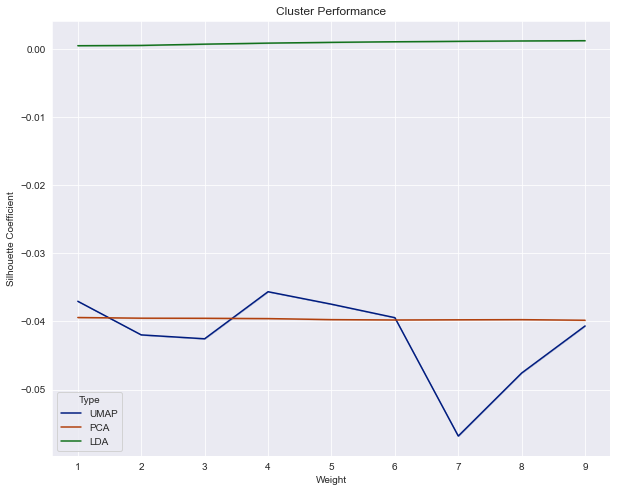

In [36]:
cluster_performance = pd.melt(amazon_results_df, id_vars = ['Weight'], value_vars=['UMAP', 'PCA', 'LDA'], var_name = 'Type', value_name = 'Silhouette Coefficient')

plt.clf()
plt.figure(figsize=(10,8))
sns.set_style("darkgrid")
sns.lineplot(data=cluster_performance, x='Weight', y='Silhouette Coefficient', hue='Type', palette="dark").set(title="Cluster Performance")
plt.savefig('images\\multiclass_cluster_performance.png')

In [25]:
plt.figure(figsize=(15,10))
sns.set_style("darkgrid")
plt.clf()

<Figure size 1080x720 with 0 Axes>

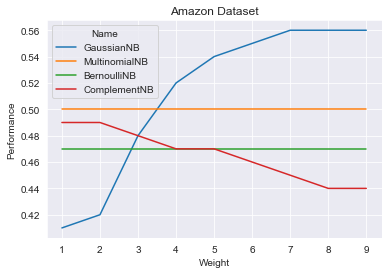

In [26]:
amazon_results_df.reset_index(inplace=True)
sns.lineplot(data=amazon_results_df, x='Weight', y='Performance', hue='Name').set(title="Amazon Dataset")
plt.show()